# 15-12-28

Right now the masks for centroid finding are the shape of the contour. PS3 uses a circle centered on the peak of the contour. I'd like to compare these two strategies to see if they give radically different results

In [1]:
# Import Modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2,ifft2,fftshift
from speckle_fns import fits_import, circ_filter1
from speckle_fns import deconv0,deconv1, postprocess
from speckle_fns import filter_lpf, filter_hpf, filter_interference
from speckle_fns import fits_view
import sys
import cv2
import math

%matplotlib inline

In [2]:
# Folder containing FITS files
fileDirectory = '/home/niels/Documents/FITS/'

# Filenames (without extensions) of the Double/Reference pairs
# Preprocessed files must have _PSD terminations on them in the same folder
filenames=[ ['KP330','KP331'], 
            ['KP332','KP333'], 
            ['KP334','KP335'], 
            ['KP336','KP338'], 
            ['KP339','KP340'],
            ['KP341','KP342'] ]

Filename: /home/niels/Documents/FITS/KP330.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      62   (512, 512, 1000)   float32   

Filename: /home/niels/Documents/FITS/KP331.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      62   (512, 512, 1000)   float32   

Filename: /home/niels/Documents/FITS/KP330_PSD.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (512, 512)   float64   

Filename: /home/niels/Documents/FITS/KP331_PSD.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (512, 512)   float64   



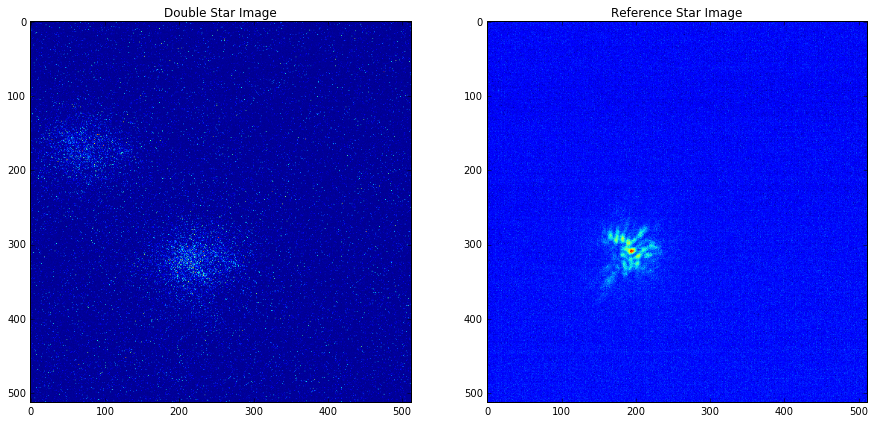

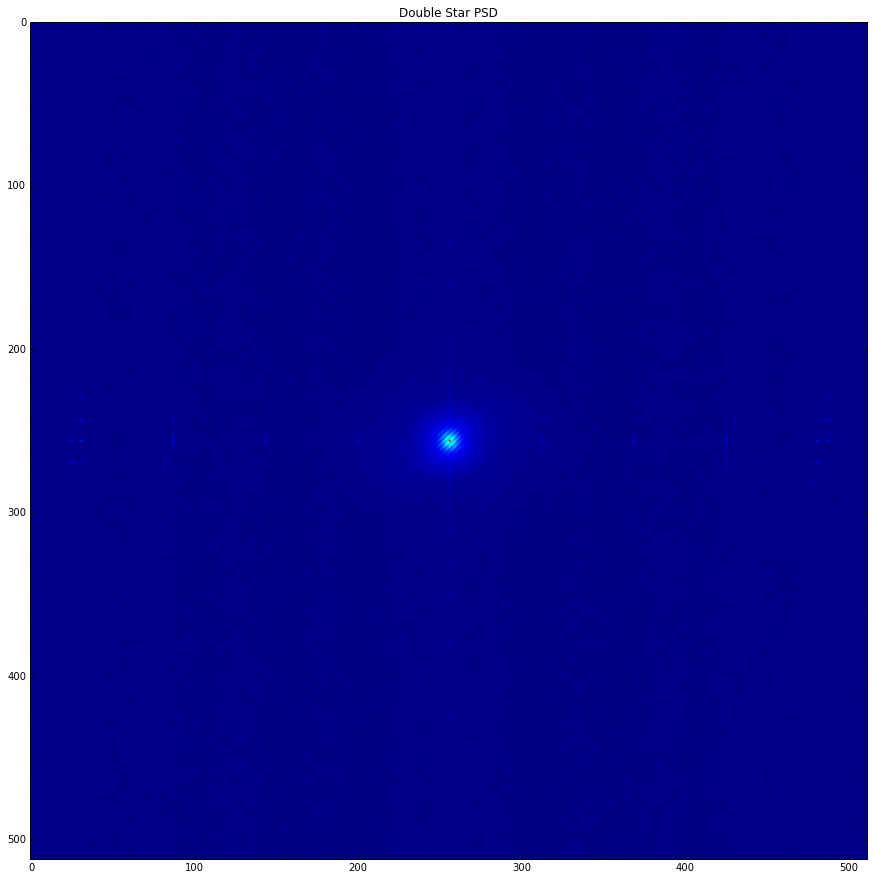

In [3]:
# Select which set of data to use:
k = 0

# View sample fits images:
imgDoubleStar = fits_view(fileDirectory+filenames[k][0]+'.fits',0)
imgSingleStar = fits_view(fileDirectory+filenames[k][1]+'.fits',0)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(imgDoubleStar)
plt.title('Double Star Image')
plt.subplot(1,2,2)
plt.imshow(imgSingleStar)
plt.title('Reference Star Image')

# Generating Autocorrelogram
# Import FITS file data
psdDoubleStar = fits_import(fileDirectory+filenames[k][0]+'_PSD.fits').astype(float)
psdSingleStar = fits_import(fileDirectory+filenames[k][1]+'_PSD.fits').astype(float)

plt.figure(figsize=(15,15))
plt.imshow(fftshift(np.log10(psdDoubleStar)))
plt.title("Double Star PSD")


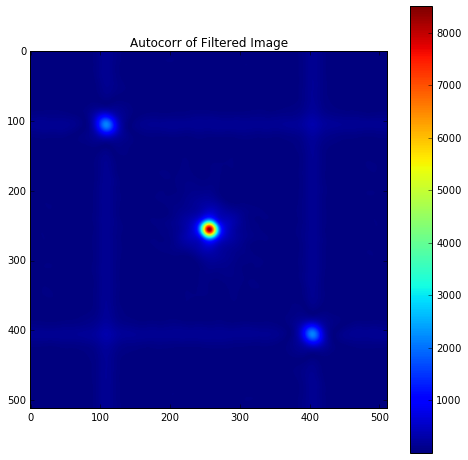

In [4]:
# Perform Deconvolution
constant = 1E-15
imgF = fftshift(deconv1(psdDoubleStar, psdSingleStar, constant))

# Filter PSD:
imgF_filtered = filter_interference(imgF)
imgF_filtered = filter_lpf(imgF_filtered, 10)

# Postprocess
img_autocorr = postprocess(imgF_filtered)

# Plot Image
plt.figure(figsize = (8,8))
plt.imshow(img_autocorr)
plt.title("Autocorr of Filtered Image")
plt.colorbar()


Final Threshold =  339.733236308


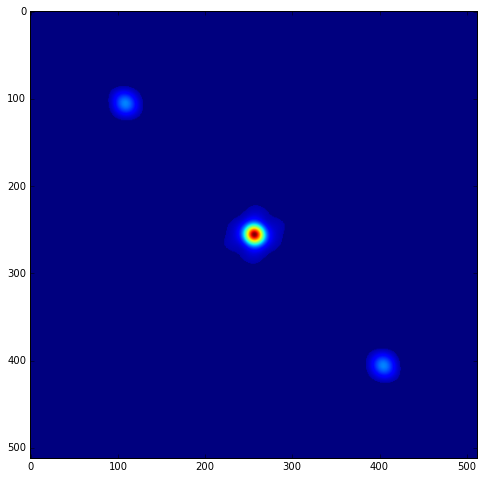

In [5]:
# Want to find the lowest threshold that we only see the 3 main lobes

# New variable for operating on
autocorr = img_autocorr

# Start thresh at max value of autocorr (assuming that is from central peak)
threshold = np.floor(autocorr.max())

# Calculate values to increment/decrement threshold by depending on height of autocorrelogram
increment_coarse = autocorr.max()/10
increment_fine   = autocorr.max()/100

# Assume we start with 1 contour visible 
num_contours = 1

# Step down threshold until we see the 3 contours we expect
while (num_contours != 3):
    # Decrement the threshold
    threshold = threshold - increment_fine
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    
    if threshold < 0:
        print("Error in finding 3 contours")
        sys.exit()
        
# Calculate indices in image above threshold
above_thresh_i = autocorr > threshold
    
# Create thresholded image
autocorr_thresh = np.zeros(np.shape(autocorr))
autocorr_thresh[above_thresh_i] = 255
autocorr_thresh = autocorr_thresh.astype(np.uint8)
        
#print(threshold)
#plt.imshow(autocorr_thresh)

# Now we've found our 3 main contours. Keep stepping down until we don't see 3 anymore
# Can be less than 3 if they start to blend together, or more than 3 if other noise in
#  image appears
while (num_contours == 3):
    # Decrement the threshold
    threshold = threshold - increment_fine
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    
    if threshold < 0:
        print("Error in moving threshold below 3 contours")
        sys.exit()
        
# Calculate indices in image above threshold
above_thresh_i = autocorr > threshold
    
# Create thresholded image
autocorr_thresh = np.zeros(np.shape(autocorr))
autocorr_thresh[above_thresh_i] = 255
autocorr_thresh = autocorr_thresh.astype(np.uint8)
        
#print(threshold)
#plt.imshow(autocorr_thresh)

# Step back up in threshold until we are back to 3 contours
while (num_contours != 3):
    # Decrement the threshold
    threshold = threshold + increment_fine
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)    
    
    if threshold > autocorr.max():
        print("Error in moving threshold back up to 3 contours")
        sys.exit()

# Calculate indices in image above threshold
above_thresh_i = autocorr > threshold
    
# Create thresholded image
autocorr_thresh = np.zeros(np.shape(autocorr))
autocorr_thresh[above_thresh_i] = 1
autocorr_thresh = autocorr_thresh.astype(np.uint8)

# Display results
print("Final Threshold = ",threshold)
plt.figure(figsize=(8,8))
plt.imshow(np.multiply(autocorr_thresh,autocorr))

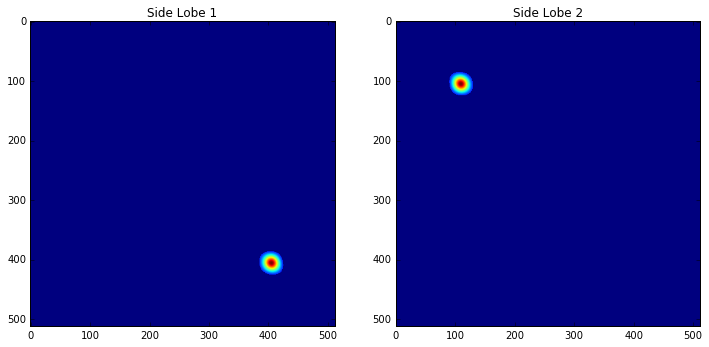

In [6]:
## Now that we have the contours, we want to find their centroids for sorting purposes
centroid = np.zeros((3,2))

for i in np.arange(3):
    # Calculating Image Moment/Raw Moment of contour
    M = cv2.moments(contours[i])
    
    # Calculate centroid X and Y components 
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    centroid[i] = (cy, cx)
    
## Find the central contour
# Center pixel indices
center = np.divide(np.shape(autocorr),2)
center_distance = np.zeros(3)

# Calculate distance from each centroid to center of image
for i in np.arange(3):
    center_distance[i] = np.linalg.norm(centroid[i] - center)

# Get index of central contour as contour with min distance to center
i = np.where(center_distance == center_distance.min())
i_center = i[0]

# Calculate central contour mask
mask_center = np.zeros(np.shape(autocorr))
cv2.drawContours(mask_center,contours,i_center,(1,1,1),-1)

## Finding indices of side lobes
# Possible indices of side lobes
i_side_lobes = [0,1,2]
# Remove the center lobe index
i_side_lobes.remove(i_center)

# Make empty mask images
mask_side = np.zeros((2,np.shape(autocorr)[0],np.shape(autocorr)[1]))
lobe_side = np.zeros((2,np.shape(autocorr)[0],np.shape(autocorr)[1]))

# Create masks and calculate side lobes
for i in np.arange(2):
    cv2.drawContours(mask_side[i],contours,i_side_lobes[i],(1,1,1),-1)
    lobe_side[i] = (np.multiply(autocorr,mask_side[i]))#.astype(np.uint8)

# Display masked side lobes
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(lobe_side[0])
plt.title("Side Lobe 1")
plt.subplot(1,2,2)
plt.imshow(lobe_side[1])
plt.title("Side Lobe 2")

[[ 403.  406.]
 [ 109.  106.]]


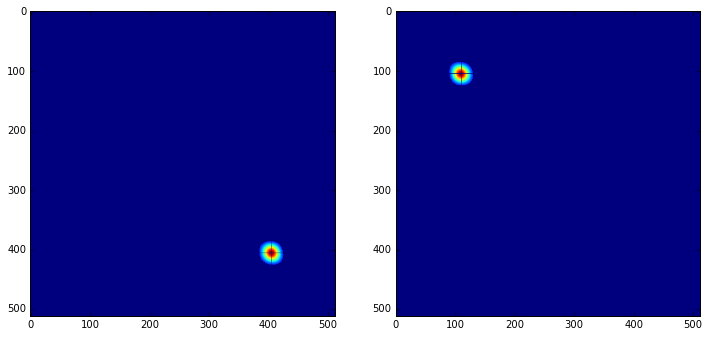

In [7]:
## Want to find peak locations of each side lobe image
# Array to hold peak values
lobe_peak = np.zeros((2,2))

# Find peak values
for i in np.arange(2):
    peak = np.where(lobe_side[i] == lobe_side[i].max())
    lobe_peak[i,1] = peak[0][0] # Assigning Y value of peak
    lobe_peak[i,0] = peak[1][0] # Assigning X value of peak
    
# Create images of sidelobes with peaks marked
lobe_side_peak = np.array(lobe_side)

# Put lines on sidelobe 0
lobe_side_peak[0,:,np.round(lobe_peak[0,0]).astype(int)] = 0
lobe_side_peak[0,np.round(lobe_peak[0,1]).astype(int),:] = 0

# Put lines on sidelobe 1
lobe_side_peak[1,:,np.round(lobe_peak[1,0]).astype(int)] = 0
lobe_side_peak[1,np.round(lobe_peak[1,1]).astype(int),:] = 0   

# View peak locations
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(lobe_side_peak[0])
plt.subplot(1,2,2)
plt.imshow(lobe_side_peak[1])

# Print peak locations
print(lobe_peak)

In [8]:
## Finding radius of circle centered on peak that fits inside contour

lobe_mask_radius = np.zeros(2) # Radius of circles to be calculated 
lobe_mask_radius.fill(math.inf) # Initial value = Infinite

# Calculate for each side lobe
for i in np.arange(2):
    # For each point on contour
    for perimeter_point in contours[i_side_lobes[i]]: 
        # Calculating distance between peak and present contour point
        distance = np.linalg.norm(perimeter_point - lobe_peak[i])
        # Save the minimum value of previously calculated min radius and present calc
        lobe_mask_radius[i] = min([lobe_mask_radius[i],distance])
     
print(lobe_mask_radius)

[ 18.38477631  18.38477631]


# 15-12-29

Now that we are finding the minimum radius, lets draw the circles to create the masks and apply the masks

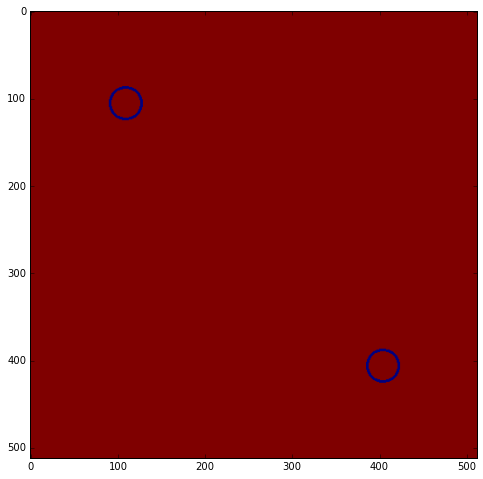

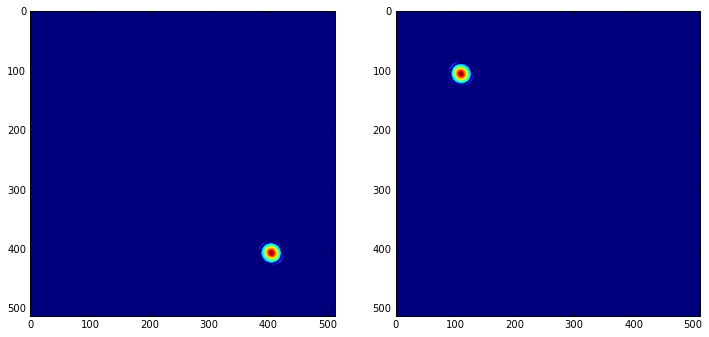

In [16]:
# Confirming that these circles are centered on the maximum value

# Creating marked images of side lobes
lobe_side_marked = np.zeros((2,512,512))

# Creating fully filled in mask
peak_mask = np.zeros((512,512,3))
peak_mask.fill(1)

# Marking the mask with circles centered on peaks
cv2.circle(peak_mask, (lobe_peak[0,0].astype(np.uint16),lobe_peak[0,1].astype(np.uint16)), lobe_mask_radius[0].astype(np.uint8), (0,0,0), 2)
cv2.circle(peak_mask, (lobe_peak[1,0].astype(np.uint16),lobe_peak[1,1].astype(np.uint16)), lobe_mask_radius[1].astype(np.uint8), (0,0,0), 2)

# Apply the mask to the autocorrelogram
lobe_side_marked[0] = peak_mask[:,:,0]*lobe_side[0]
lobe_side_marked[1] = peak_mask[:,:,0]*lobe_side[1]

# View peak mask
plt.figure(figsize = (8,8))
plt.imshow(peak_mask[:,:,0])

# View marked side lobes
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(lobe_side_marked[0])
plt.subplot(1,2,2)
plt.imshow(lobe_side_marked[1])